In [75]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from random import shuffle
from copy import deepcopy
import networkx as nx

In [2]:
class siRNN(nn.Module):
    def __init__(self, nin, nnode, nout, x0, dtRtau=0.1):
        # x0 must be a variable
        super(siRNN, self).__init__()
        self.l11 = nn.Linear(nin, nnode) # BU + b
        self.l12 = nn.Linear(nnode, nnode, bias=False) #J Y_i-1
        self.x = x0 #initialize states. x0 should be a tensor/variable?
        self.dtRtau = dtRtau
        self.lout = nn.Linear(nnode, nout) # Output of the network
    
    def forward(self, u):
        # u must be a variable
        self.r = F.tanh(self.x) # Output of each neuron in terms of firing/not firing
        self.x = self.x*(1-self.dtRtau) + self.dtRtau*(self.l11(u) + self.l12(self.r))
        #self.output = F.tanh(self.lout(self.x))
        self.output = self.lout(self.x)
        return self.output, self.x, self.r
    
    def weight_init(self):
        nn.init.sparse(self.l12.weight, sparsity=0.1, std=0.01)
    
    def state_reset(self, x0):
        self.x = x0

In [9]:
# Training set

# u = [uc, um, ucc, ucm]T
# ucc, ucm are either 0 or 1
# Motion context: ucm = 1, ucc=0
# Color context: ucm = 0, ucc=1
# uc = um = d + rho

# rho: Noise, zero-mean, std=1
# d: offset. uniform between [0, 0.1875]

# First pick d from a uniform([-0.1875, +0.1875]) and then identify the appropriate
# target. 

# Convert both to time-series. with the correct protocol.
# input: 1ms in the begining, size 2
# target: 1ms to 0 in the beginning. 1ms to correct choice at T.

# N of trials: 160000

#trial_1 
dt = 1 # in ms
trial_len = 750*dt
#trial_len = 200*dt
ntrials = 1000 

train_data = []


for i in range(ntrials):
    rho_temp = np.random.normal(0, 1, size=trial_len) # noise @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    #rho_temp = np.random.normal(0, 0.1, size=trial_len) # noise @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    dc_temp = np.random.uniform(-0.1875, 0.1875)
    uc_temp = dc_temp + rho_temp
    dm_temp = np.random.uniform(-0.1875, 0.1875)
    um_temp = dm_temp + rho_temp
    
    if i < (ntrials/2):
        ucc_temp,ucm_temp = 0,1
        target_temp = np.sign(dm_temp)
    else:
        ucc_temp,ucm_temp = 1,0
        target_temp = np.sign(dc_temp)
        
    u_temp = [uc_temp, um_temp, ucc_temp, ucm_temp]
    train_data.append([u_temp , target_temp])

shuffle(train_data)

In [4]:
## Creating an instance
nin = 4
nnode = 100
#nnode = 50
nout = 1
#x0 = Variable(torch.randn(nnode).cuda())
x0 = Variable(torch.randn(nnode))
myrnn = siRNN(nin, nnode, nout, x0)
#myrnn.cuda()
myrnn.weight_init()

In [10]:
# Training with BP during the whole trial
lr = 0.0003
optimizer = optim.Adam(myrnn.parameters(), lr = lr)
criterion = nn.L1Loss()

#zero = Variable(torch.cuda.FloatTensor([0]))
#zero = Variable(torch.FloatTensor([0]))

allloss =[]
alloutput =[]
alltarget = []

for i, trial in enumerate(train_data):
    u = trial[0]
    u[2] = u[2]*np.ones_like(u[0])
    u[3] = u[3]*np.ones_like(u[0])
    #input = Variable(torch.cuda.FloatTensor(u))
    #target = Variable(torch.cuda.FloatTensor([trial[1]]))
    input = Variable(torch.FloatTensor(u))
    target = Variable(torch.FloatTensor([trial[1]]))
    
    #alloutput, allxn, allrn =[], [], []
    myrnn.state_reset(x0)
    for t in range(input.shape[1]):
        output, xn, rn = myrnn(input[:,t])
        #alloutput.append(output.data.numpy())
        #allxn.append(xn.data.numpy())
        #allrn.append(rn.data.numpy())
        #if t==0:
            #optimizer.zero_grad()
            #loss1 = criterion(output, zero)
            #loss1.backward(retain_graph=True)
            #optimizer.step()
        if t>input.shape[1]/1.1:
            optimizer.zero_grad()
            loss2 = criterion(output, target)
            loss2.backward(retain_graph=True)
            optimizer.step()
            
    alloutput.append(output.data)    
    alltarget.append(target.data)
    allloss.append(loss2.data)
    if i%10 ==0:
        print(i," out of ", ntrials, " trials processed. Loss=", loss2)

0  out of  1000  trials processed. Loss= Variable containing:
 0.6002
[torch.FloatTensor of size 1]

10  out of  1000  trials processed. Loss= Variable containing:
 0.1451
[torch.FloatTensor of size 1]

20  out of  1000  trials processed. Loss= Variable containing:
1.00000e-02 *
  3.1711
[torch.FloatTensor of size 1]

30  out of  1000  trials processed. Loss= Variable containing:
1.00000e-02 *
  4.2391
[torch.FloatTensor of size 1]

40  out of  1000  trials processed. Loss= Variable containing:
1.00000e-02 *
  3.1341
[torch.FloatTensor of size 1]

50  out of  1000  trials processed. Loss= Variable containing:
1.00000e-02 *
  5.0434
[torch.FloatTensor of size 1]

60  out of  1000  trials processed. Loss= Variable containing:
1.00000e-02 *
  1.7317
[torch.FloatTensor of size 1]

70  out of  1000  trials processed. Loss= Variable containing:
 0.1326
[torch.FloatTensor of size 1]

80  out of  1000  trials processed. Loss= Variable containing:
 0.2600
[torch.FloatTensor of size 1]

90  out 

730  out of  1000  trials processed. Loss= Variable containing:
1.00000e-02 *
  6.7322
[torch.FloatTensor of size 1]

740  out of  1000  trials processed. Loss= Variable containing:
 2.1720
[torch.FloatTensor of size 1]

750  out of  1000  trials processed. Loss= Variable containing:
1.00000e-02 *
  6.1580
[torch.FloatTensor of size 1]

760  out of  1000  trials processed. Loss= Variable containing:
 0.1578
[torch.FloatTensor of size 1]

770  out of  1000  trials processed. Loss= Variable containing:
1.00000e-02 *
  5.7380
[torch.FloatTensor of size 1]

780  out of  1000  trials processed. Loss= Variable containing:
1.00000e-02 *
  5.0343
[torch.FloatTensor of size 1]

790  out of  1000  trials processed. Loss= Variable containing:
1.00000e-03 *
  6.8331
[torch.FloatTensor of size 1]

800  out of  1000  trials processed. Loss= Variable containing:
 0.2764
[torch.FloatTensor of size 1]

810  out of  1000  trials processed. Loss= Variable containing:
1.00000e-02 *
  4.6896
[torch.FloatTe

In [11]:
# Save the model
torch.save(myrnn.state_dict(), 'siRNNfin2-2')
# Load the trained model to catch up with work.
#den_net.load_state_dict(torch.load('siRNN23'))

Performance =  98.1 %


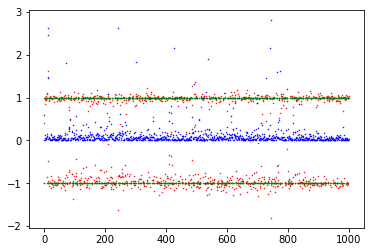

In [13]:
n_ax = range(len(alloutput))
alloutput=np.asarray(alloutput)
alltarget=np.asarray(alltarget)
allloss=np.asarray(allloss)

perf=100*np.sum(allloss<1)/len(allloss)
print("Performance = ",perf, "%")
plt.plot(n_ax, alloutput, '.r', n_ax, alltarget,'.g', allloss, '.b', markersize=1)
#plt.savefig('siRNNfin2-result',dpi=300,format='pdf')

In [17]:
# Testing

# Generate test set

#dt = 1 # in ms
#trial_len = 750*dt
ntrials = 500 

test_data = []


for i in range(ntrials):
    rho_temp = np.random.normal(0, 1, size=trial_len)
    dc_temp = np.random.uniform(-0.1875, 0.1875)
    uc_temp = dc_temp + rho_temp
    dm_temp = np.random.uniform(-0.1875, 0.1875)
    um_temp = dm_temp + rho_temp
    
    if i < (ntrials/2):
        ucc_temp,ucm_temp = 0,1
        target_temp = np.sign(dm_temp)
        real_offset = dm_temp
    else:
        ucc_temp,ucm_temp = 1,0
        target_temp = np.sign(dc_temp)
        real_offset = dc_temp
        
    u_temp = [uc_temp, um_temp, ucc_temp, ucm_temp]
    test_data.append([u_temp , target_temp, real_offset])

shuffle(test_data)

In [102]:
# Training with BP during the whole trial
#lr = 0.0003
#optimizer = optim.Adam(myrnn.parameters(), lr = lr)
criterion = nn.L1Loss()

#zero = Variable(torch.cuda.FloatTensor([0]))
#zero = Variable(torch.FloatTensor([0]))

tallloss =[]
talloutput =[]
talltarget = []
tallrn =[]
tallxn =[]

for i, trial in enumerate(test_data):
    u = trial[0]
    u[2] = u[2]*np.ones_like(u[0])
    u[3] = u[3]*np.ones_like(u[0])
    #input = Variable(torch.cuda.FloatTensor(u))
    #target = Variable(torch.cuda.FloatTensor([trial[1]]))
    input = Variable(torch.FloatTensor(u))
    target = Variable(torch.FloatTensor([trial[1]]))
    
    #alloutput, allxn, allrn =[], [], []
    myrnn.state_reset(x0)
    for t in range(input.shape[1]):
        output, xn, rn = myrnn(input[:,t])
        if i==7:
            tallrn.append(rn.data.numpy())
            tallxn.append(xn.data.numpy())
        #alloutput.append(output.data.numpy())
        #allxn.append(xn.data.numpy())
        #allrn.append(rn.data.numpy())
        #if t==0:
            #optimizer.zero_grad()
            #loss1 = criterion(output, zero)
            #loss1.backward(retain_graph=True)
            #optimizer.step()
        if t>input.shape[1]/1.1:
            #optimizer.zero_grad()
            tloss2 = criterion(output, target)
            #loss2.backward(retain_graph=True)
            #optimizer.step()
            
    talloutput.append(output.data)
    #tallrn.append(rn.data.numpy())
    talltarget.append(target.data)
    tallloss.append(loss2.data)
    if i%10 ==0:
        print(i," out of ", ntrials, " trials processed. Loss=", tloss2)

0  out of  500  trials processed. Loss= Variable containing:
 0.3552
[torch.FloatTensor of size 1]

10  out of  500  trials processed. Loss= Variable containing:
 0.1927
[torch.FloatTensor of size 1]

20  out of  500  trials processed. Loss= Variable containing:
 2.1045
[torch.FloatTensor of size 1]

30  out of  500  trials processed. Loss= Variable containing:
 0.4765
[torch.FloatTensor of size 1]

40  out of  500  trials processed. Loss= Variable containing:
 2.1962
[torch.FloatTensor of size 1]

50  out of  500  trials processed. Loss= Variable containing:
 2.4208
[torch.FloatTensor of size 1]

60  out of  500  trials processed. Loss= Variable containing:
 1.9855
[torch.FloatTensor of size 1]

70  out of  500  trials processed. Loss= Variable containing:
 0.4979
[torch.FloatTensor of size 1]

80  out of  500  trials processed. Loss= Variable containing:
 0.4513
[torch.FloatTensor of size 1]

90  out of  500  trials processed. Loss= Variable containing:
 0.2764
[torch.FloatTensor of 

Performance =  100.0 %


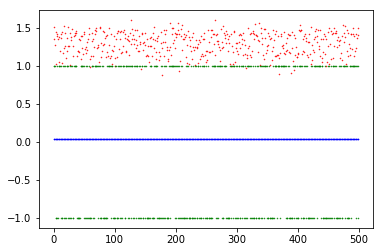

In [104]:
n_ax = range(len(talloutput))
talloutput=np.asarray(talloutput)
talltarget=np.asarray(talltarget)
tallloss=np.asarray(tallloss)
tallrn=np.asarray(tallrn)
tallxn=np.asarray(tallxn)

perf=100*np.sum(tallloss[0:200]<1)/len(tallloss[0:200])
print("Performance = ",perf, "%")
plt.plot(n_ax, talloutput, '.r', n_ax, talltarget,'.g', tallloss, '.b', markersize=1)
#plt.savefig('siRNNfin2-result',dpi=300,format='pdf')

In [24]:
str_conn = myrnn.l12.weight.data.numpy()

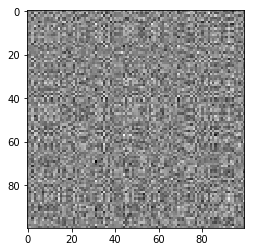

In [25]:
plt.imshow(str_conn, cmap='gray')

(array([    3.,    24.,   306.,  1341.,  2734.,  2947.,  1904.,   649.,
           86.,     6.]),
 array([-0.25782287, -0.20828186, -0.15874085, -0.10919983, -0.05965882,
        -0.01011781,  0.03942321,  0.08896422,  0.13850523,  0.18804625,
         0.23758726]),
 <a list of 10 Patch objects>)

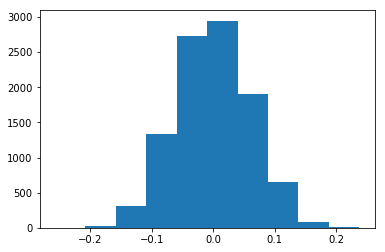

In [46]:
# Weight distribution
plt.hist(str_conn.flatten())

In [ ]:
# Node degree distribution


In [72]:
str_conn_abs = np.abs(deepcopy(str_conn))
thresh=0.14
str_conn_b[str_conn_abs<thresh]=0
str_conn_b[str_conn_abs>=thresh]=1

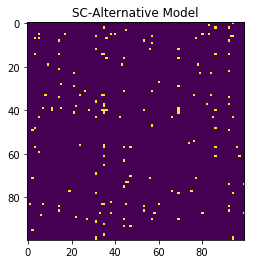

In [76]:
plt.imshow(str_conn_b)
plt.title('SC-Alternative Model')

/N/soft/rhel6/anaconda3/4.4.0/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/N/soft/rhel6/anaconda3/4.4.0/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/N/soft/rhel6/anaconda3/4.4.0/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/N/soft/rhel6/anaconda3/4.4.0/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0


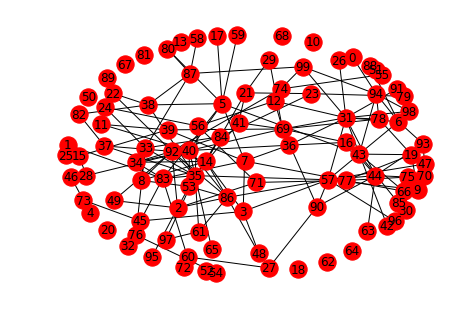

In [74]:
D = nx.DiGraph(str_conn_b)
D_un = nx.Graph(D)  # convert D to undirected graph
#D_un.remove_node(72)
nx.draw(D_un, with_labels=True)

In [64]:
D_cliques=list(nx.find_cliques(D_un))

In [65]:
D_cliques

[[0, 94],
 [1, 83],
 [2, 71],
 [3, 48],
 [3, 57],
 [3, 45],
 [3, 7],
 [4],
 [5, 38],
 [5, 7],
 [5, 43],
 [5, 80],
 [5, 17],
 [5, 59],
 [7, 83],
 [7, 77],
 [7, 39],
 [8, 14],
 [9, 57],
 [10],
 [11, 40],
 [11, 39],
 [13],
 [14, 84],
 [14, 21],
 [14, 92, 34],
 [14, 92, 86],
 [15, 39],
 [16, 36],
 [16, 69],
 [16, 44],
 [18],
 [19, 43],
 [19, 77],
 [19, 78],
 [20],
 [22, 92],
 [23, 84],
 [24, 33],
 [25],
 [27, 60],
 [28],
 [29, 69],
 [30],
 [31, 98],
 [31, 99],
 [31, 36],
 [31, 69, 12],
 [31, 69, 78],
 [31, 6, 57],
 [31, 26],
 [31, 91],
 [32],
 [33, 84],
 [33, 87],
 [34, 40],
 [35, 65],
 [35, 83],
 [35, 56],
 [35, 92],
 [35, 61],
 [37],
 [38, 82],
 [38, 87],
 [39, 69],
 [40, 69],
 [40, 36],
 [40, 53],
 [41, 69],
 [42],
 [43, 85],
 [44, 57, 90],
 [44, 75],
 [46],
 [47, 57],
 [47, 70],
 [48, 86],
 [49],
 [50],
 [51],
 [52],
 [53, 84],
 [53, 86],
 [54, 76],
 [55],
 [56, 12],
 [58],
 [60, 83],
 [61, 86],
 [62],
 [63],
 [64],
 [66, 77],
 [67],
 [68],
 [72],
 [73],
 [74, 92],
 [75, 77],
 [79],
 [

In [105]:
tallrn_c=np.sign(tallrn).transpose()
tallxn_c=tallxn.transpose()

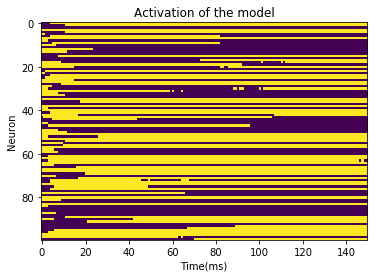

In [110]:
ax=plt.axes()
plt.imshow(np.sign(tallrn[0:150]).transpose())
ax.set_xlabel('Time(ms)')
ax.set_ylabel('Neuron')
ax.set_title('Activation of the model')

In [96]:
# Resample: Sum up the spikes in each sr samples
def downsample(sigs, sr):
    new_len = int(sigs.shape[1]/sr)
    new_sigs = np.zeros([sigs.shape[0], new_len], dtype=sigs.dtype)
    for i in range(new_len):
        new_sigs[:, i] = np.sum(sigs[:, sr*i:sr*(i+1)], axis=1)
    return new_sigs

In [97]:
sr = 50
resp = downsample(tallrn_c, sr) # Resample
# Calculate Functional Connectivity
fc1 = np.corrcoef(resp)


/N/soft/rhel6/anaconda3/4.4.0/lib/python3.6/site-packages/numpy/lib/function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/N/soft/rhel6/anaconda3/4.4.0/lib/python3.6/site-packages/numpy/lib/function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


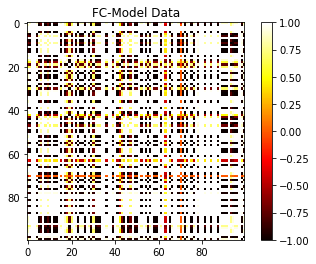

In [98]:
plt.imshow(fc1, cmap='hot')
plt.colorbar()
plt.title('FC-Model Data')